# Convolutional Neural Networks for Jet-Images
Author: Javier Duarte

## Load numpy arrays
Here, we load the numpy arrays containing the 4D tensors of "jet-images" (see https://arxiv.org/pdf/1511.05190.pdf)

In [1]:
import h5py

h5f = h5py.File("data/jet_images.h5", "r")

jet_images_dict = {}
jet_images_dict['QCD'] = h5f['QCD'][()]
jet_images_dict['TT'] = h5f['TT'][()]

h5f.close()

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-pippkgs_depscipy/3.0-omkpbe4/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
# 4D tensor (tensorflow backend)
# 1st dim is jet index
# 2nd dim is eta bin
# 3rd dim is phi bin
# 4th dim is pt value (or rgb values, etc.)
print(jet_images_dict['QCD'].shape)
print(jet_images_dict['TT'].shape)

(3305, 30, 30, 1)
(1821, 30, 30, 1)


## Plotting jet-images
Let's plot some jet-images (individual jets and averaged over all jets)

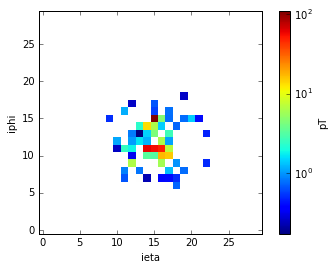

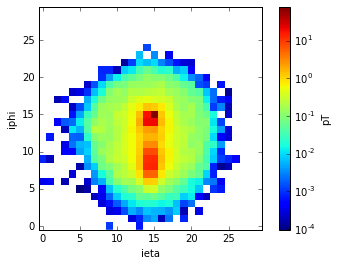

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# plot one W jet
i = 7
plt.figure('W') 
plt.imshow(jet_images_dict['TT'][i,:,:,0].T, norm=mpl.colors.LogNorm(), origin='lower', interpolation='none')
cbar = plt.colorbar()
cbar.set_label('pT')
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.show()

# plot average W jet
ave_jet_image_TT = np.sum(jet_images_dict['TT'][:,:,:,0],axis=0)/len(jet_images_dict['TT'])
plt.figure('W') 
plt.imshow(ave_jet_image_TT.T, norm=mpl.colors.LogNorm(), origin='lower', interpolation='none')
cbar = plt.colorbar()
cbar.set_label('pT')
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.show()

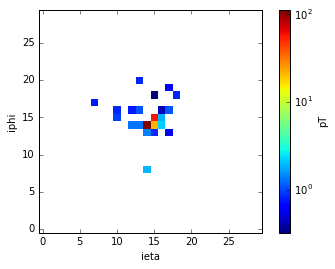

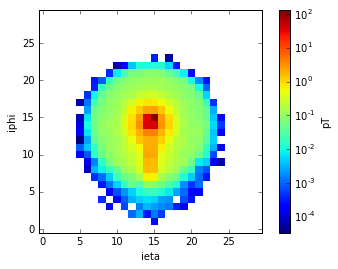

In [20]:
# plot one QCD jet
i = 7
plt.figure() 
plt.imshow(jet_images_dict['QCD'][i,:,:,0].T, norm=mpl.colors.LogNorm(), origin='lower', interpolation='none')
cbar = plt.colorbar()
cbar.set_label('pT')
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.show()

# plot average QCD jet
ave_jet_image_QCD = np.sum(jet_images_dict['QCD'][:,:,:,0],axis=0)/len(jet_images_dict['QCD'])
plt.figure() 
plt.imshow(ave_jet_image_QCD.T, norm=mpl.colors.LogNorm(), origin='lower',  interpolation='none')
cbar = plt.colorbar()
cbar.set_label('pT')
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.show()

In [115]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dropout, Dense, BatchNormalization, Concatenate
from keras.regularizers import l1,l2
nx = 30
ny = 30
input_layer = Input(shape=(nx, ny, 1), name='input')
layer = BatchNormalization(momentum=0.6, name='batchnorm_0')(input_layer)
#skip = Flatten(name='skip')(input_layer) # skip connection for connecting to final dense
layer = Conv2D(32, (11, 11), strides=(1, 1), padding='same', activation='relu', name='conv2d_1', kernel_regularizer=l2(0.01))(layer)
layer = BatchNormalization(momentum=0.6, name='batchnorm_1')(layer)
layer = MaxPool2D(pool_size=(2, 2), name='maxpool2d_1')(layer)
layer = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv2d_2', kernel_regularizer=l2(0.01))(layer)
layer = BatchNormalization(momentum=0.6, name='batchnorm_2')(layer)
layer = MaxPool2D(pool_size=(3, 3), name='maxpool2d_2')(layer)
layer = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv2d_3', kernel_regularizer=l2(0.01))(layer)
layer = BatchNormalization(momentum=0.6, name='batchnorm_3')(layer)
layer = MaxPool2D(pool_size=(3, 3), name='maxpool2d_3')(layer)
layer = Flatten(name='flatten')(layer)
#layer = Concatenate(axis=-1, name='concat')([layer, skip])
layer = Dense(64, activation='relu', name='dense', kernel_regularizer=l2(0.01))(layer)
output_layer = Dense(1, activation='sigmoid', name='output', kernel_regularizer=l2(0.01))(layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 30, 30, 1)         0         
_________________________________________________________________
batchnorm_0 (BatchNormalizat (None, 30, 30, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        3904      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 30, 30, 32)        128       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 32)        9248      
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 15, 15, 32)        128       
__________

In [68]:
jet_images = np.concatenate([jet_images_dict['TT'],
                             jet_images_dict['QCD']])
jet_labels = np.concatenate([np.ones(len(jet_images_dict['TT'])), 
                             np.zeros(len(jet_images_dict['QCD']))])

X = jet_images
Y = jet_labels

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

print 'number of W jets for training/validation: %i'%np.sum(Y_train_val==1)
print 'number of QCD jets for training/validation: %i'%np.sum(Y_train_val==0)

print 'number of W jets for testing: %i'%np.sum(Y_test==1)
print 'number of QCD jets for testing: %i'%np.sum(Y_test==0)

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

number of W jets for training/validation: 1459
number of QCD jets for training/validation: 2641
number of W jets for testing: 362
number of QCD jets for testing: 664


## Run training and visualize performance with ROC curves
Here, we run the training and visualize the performance of our model with a ROC curve for each cross validation sample.

In [120]:
# Train classifier
history = model.fit(X_train_val, Y_train_val, epochs=200, batch_size=1024, verbose=1, callbacks=[early_stopping], validation_split=0.25)

Train on 3075 samples, validate on 1025 samples
Epoch 1/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.4399 - acc: 0.9076 - val_loss: 0.4785 - val_acc: 0.8937
Epoch 2/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.4433 - acc: 0.9073 - val_loss: 0.4734 - val_acc: 0.8937
Epoch 3/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.4671 - acc: 0.9008 - val_loss: 0.4927 - val_acc: 0.8888
Epoch 4/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.4698 - acc: 0.9031 - val_loss: 0.4708 - val_acc: 0.8985
Epoch 5/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.4450 - acc: 0.9086 - val_loss: 0.4840 - val_acc: 0.8878
Epoch 6/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.4400 - acc: 0.9096 - val_loss: 0.4729 - val_acc: 0.8995
Epoch 7/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.4458 - acc: 0.9060 - val_loss: 0.4799 - val_acc: 0.8878
Epoch 8

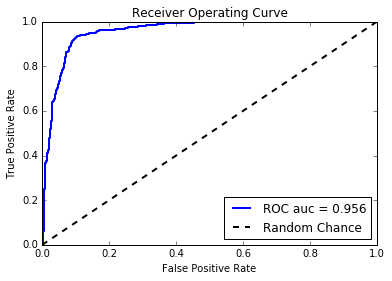

In [121]:
import matplotlib.pyplot as plt

# Plot ROC
Y_predict = model.predict(X_test)

# Compute ROC curve and area the curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='blue', label='ROC auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Random Chance')
plt.xlim([0, 1])
plt.ylim([0, 1])
#plt.semilogx()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')
plt.legend(loc="lower right")
plt.show()